# Setup

In [581]:
import keras.metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from IPython.display import Javascript
from nbconvert import HTMLExporter
import time
import os
import tempfile
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)
current_file = 'TAD_VAE_Classifier.ipynb'

## Set notebook output name here:
output_file = 'TAD_VAEclass_local_fullseq_encoded_NoNorm_512.html'

# Data Import

In [582]:
np.random.seed(42)

## randomly select ~44k TCRs from MAIT pool - this saves having to import the whole dataset only to subset later.
rng = np.random.default_rng()
files = rng.choice(range(1,98), size=97, replace=False)

## Read in data
data = []
## TODO: write method to save names of files used in training/testing
for i in range(1,98):
    data.append(pd.read_csv("../data/mait/pbert/MAIT_betaSeq_recon_"+str(i)+"_pbert_local.csv", header=None))
mait_loc = pd.concat(data, axis=0, ignore_index=False)

del data
mait_local = mait_loc.to_numpy()
del mait_loc

data = []
## max here is 133
files = rng.choice(range(1,95), size=94, replace=False)
for i in range(1,95):
    data.append(pd.read_csv("../data/tcr_beta/pbert/tcr_beta_seq_"+str(i)+"_pbert_local.csv", header=None))
vdjdb_loc = pd.concat(data)
del data
vdjdb_local = vdjdb_loc.to_numpy()
print(vdjdb_local.shape)
del vdjdb_loc

data = np.append(mait_local, vdjdb_local, axis=0)

labels = np.repeat([1,0], [mait_local.shape[0], vdjdb_local.shape[0]], axis=0)
print("done")

(93856, 1562)
done


In [583]:
neg, pos = np.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 190091
    Positive: 96235 (50.63% of total)



In [584]:
print(mait_local.shape)
print(vdjdb_local.shape)
print(mait_local.shape[0] + vdjdb_local.shape[0])
print(data.shape)

print(labels)

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

(96235, 1562)
(93856, 1562)
190091
(190091, 1562)
[1 1 1 ... 0 0 0]


{0: 93856, 1: 96235}

In [585]:

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

## Center normalization
mean_val = tf.reduce_mean(train_data)
train_data = train_data - mean_val
test_data = test_data - mean_val
val_data = val_data - mean_val

## Min/Max 0,1 normalization
#min_val = tf.reduce_min(train_data)
#max_val = tf.reduce_max(train_data)
#train_data = (train_data - min_val) / (max_val - min_val)
#test_data = (test_data - min_val) / (max_val - min_val)
#val_data = (val_data - min_val) / (max_val - min_val)

### Standardized normalisation (center, scaled)
#train_centered = train_data - mean_val
#test_centered = test_data - mean_val
#min_val = tf.reduce_min(train_data)
#max_val = tf.reduce_max(train_data)
#train_scaled = (train_data - min_val) / (max_val - min_val)
#test_scaled = (test_data - min_val) / (max_val - min_val)
#train_data = (train_centered * train_scaled)
#test_data = (test_centered * test_scaled)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
print("done")

done


In [586]:
print("Data object dimensionality \n")
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

Data object dimensionality 

(121657, 1562)
(38019, 1562)
(121657,)
(38019,)


In [587]:
print("Train label counts")
print(train_labels)
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

Train label counts
[1 0 0 ... 0 1 0]


{0: 60175, 1: 61482}

In [588]:
print("Test label counts")
print(test_labels)
unique, counts = np.unique(test_labels, return_counts=True)
dict(zip(unique, counts))

Test label counts
[0 0 0 ... 0 1 0]


{0: 18787, 1: 19232}

# Define Model

In [616]:
METRICS = [
    keras.metrics.TruePositives(name="True_Pos"),
    keras.metrics.FalsePositives(name="False_Pos"),
    keras.metrics.TrueNegatives(name="True_Neg"),
    keras.metrics.FalseNegatives(name="False_Neg"),
    keras.metrics.BinaryAccuracy(name="Binary_Acc"),
    keras.metrics.Precision(name="Precision"),
    keras.metrics.Recall(name="Recall"),
    keras.metrics.AUC(name="AUC"),
    keras.metrics.AUC(name="Precision-Recall_Curve", curve="PR")
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(512, activation="relu", input_shape=(train_data.shape[1],)),
        keras.layers.Dense(256, activation="relu"),
        #keras.layers.Dense(256, activation="relu", input_shape=(train_data.shape[1],)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        #keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="softmax", bias_initializer=output_bias),
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

TypeError: Got an unexpected keyword argument 'name'

In [590]:
EPOCHS = 200
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_Precision-Recall_Curve',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [591]:
model = make_model()
model.summary()

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_397 (Dense)           (None, 512)               800256    
                                                                 
 dense_398 (Dense)           (None, 256)               131328    
                                                                 
 dense_399 (Dense)           (None, 128)               32896     
                                                                 
 dense_400 (Dense)           (None, 64)                8256      
                                                                 
 dense_401 (Dense)           (None, 32)                2080      
                                                                 
 dropout_88 (Dropout)        (None, 32)                0         
                                                                 
 dense_402 (Dense)           (None, 1)               

In [592]:
results = model.evaluate(train_data, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.9306


In [593]:
initial_bias = np.log([pos/neg])
print(initial_bias)

[0.02503142]


In [594]:
model = make_model(output_bias=initial_bias)
#model.predict(train_data)

In [595]:
results = model.evaluate(train_data, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6935


In [596]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [597]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_data,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_data, val_labels),
    verbose=0)

In [598]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_data,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_data, val_labels),
    verbose=0)

In [599]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


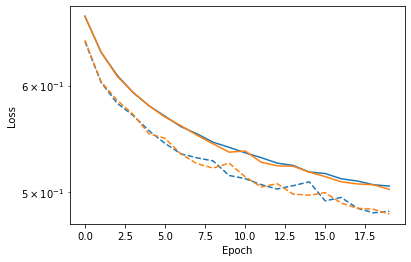

In [600]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

# Train

In [601]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_data,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler],
    validation_data=(val_data, val_labels))


Epoch 1/200
60/60 [==============================] - 10s 94ms/step - loss: 0.6744 - True_Pos: 55678.0000 - False_Pos: 34800.0000 - True_Neg: 40269.0000 - False_Neg: 21325.0000 - Binary_Acc: 0.6309 - Precision: 0.6154 - Recall: 0.7231 - AUC: 0.6939 - Precision-Recall_Curve: 0.7007 - val_loss: 0.6457 - val_True_Pos: 10076.0000 - val_False_Pos: 4336.0000 - val_True_Neg: 10558.0000 - val_False_Neg: 5445.0000 - val_Binary_Acc: 0.6784 - val_Precision: 0.6991 - val_Recall: 0.6492 - val_AUC: 0.7195 - val_Precision-Recall_Curve: 0.7113 - lr: 1.0000e-04
Epoch 2/200
60/60 [==============================] - 4s 75ms/step - loss: 0.6334 - True_Pos: 43177.0000 - False_Pos: 23091.0000 - True_Neg: 37084.0000 - False_Neg: 18305.0000 - Binary_Acc: 0.6597 - Precision: 0.6516 - Recall: 0.7023 - AUC: 0.7081 - Precision-Recall_Curve: 0.6944 - val_loss: 0.6011 - val_True_Pos: 10435.0000 - val_False_Pos: 3867.0000 - val_True_Neg: 11027.0000 - val_False_Neg: 5086.0000 - val_Binary_Acc: 0.7056 - val_Precision: 0

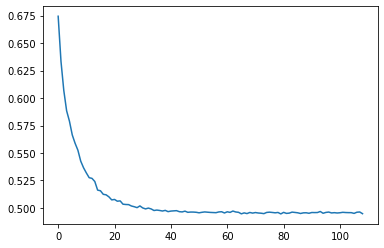

In [602]:
plt.plot(baseline_history.epoch, baseline_history.history["loss"])

In [603]:
def plot_metrics(history):
  metrics = ['loss', 'Precision-Recall_Curve', 'Precision', 'Recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();


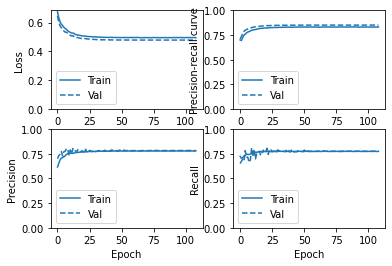

In [604]:
plot_metrics(baseline_history)


# Metrics

In [605]:
train_predictions_baseline = model.predict(train_data, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_data, batch_size=BATCH_SIZE)


(array([411., 601., 324., 222., 203., 221., 222., 227., 217., 242., 224.,
        259., 272., 338., 368., 377., 417., 486., 490., 543., 553., 580.,
        581., 579., 574., 528., 565., 552., 532., 510., 491., 480., 422.,
        435., 372., 397., 371., 337., 335., 257., 272., 244., 260., 262.,
        232., 245., 206., 245., 238., 270., 250., 258., 245., 261., 249.,
        229., 261., 269., 266., 281., 270., 264., 263., 257., 272., 313.,
        275., 294., 297., 338., 359., 331., 382., 341., 372., 412., 377.,
        426., 396., 447., 471., 505., 542., 603., 592., 633., 588., 684.,
        622., 678., 666., 708., 696., 618., 555., 472., 294., 165.,  72.,
         11.]),
 array([0.00532147, 0.01503777, 0.02475406, 0.03447036, 0.04418666,
        0.05390295, 0.06361924, 0.07333554, 0.08305184, 0.09276813,
        0.10248443, 0.11220072, 0.12191702, 0.13163331, 0.14134961,
        0.1510659 , 0.1607822 , 0.17049849, 0.18021479, 0.18993108,
        0.19964738, 0.20936367, 0.21907997, 0.

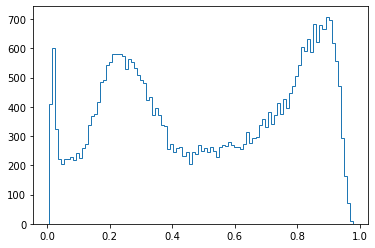

In [607]:
plt.hist(test_predictions_baseline, bins=100, histtype="step")

In [608]:
def plot_cm(labels, predictions, p=0.5):
  cm = metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  recall = cm[1][1]/(cm[1][1] + cm[0][1])
  precision = cm[1][1]/(cm[1][1] + cm[1][0])
  f1 = 2 * (precision * recall)/(precision + recall)

  print("Recall = {}".format(recall))
  print("Precision = {}".format(precision))
  print("F1 Score = {}".format(f1))
  print('Real Non-MAIT (True Negatives): ', cm[0][0])
  print('False MAIT (False Positives): ', cm[0][1])
  print('False Non-MAIT (False Negatives): ', cm[1][0])
  print('Real MAIT (True Positives): ', cm[1][1])
  print('Total MAIT: ', np.sum(cm[1]))



loss :  0.4836272895336151
True_Pos :  14923.0
False_Pos :  4285.0
True_Neg :  14502.0
False_Neg :  4309.0
Binary_Acc :  0.7739551067352295
Precision :  0.7769158482551575
Recall :  0.775946319103241
AUC :  0.8473147749900818
Precision-Recall_Curve :  0.8418264389038086

Recall = 0.7769158683881716
Precision = 0.7759463394342762
F1 Score = 0.7764308012486991
Real Non-MAIT (True Negatives):  14502
False MAIT (False Positives):  4285
False Non-MAIT (False Negatives):  4309
Real MAIT (True Positives):  14923
Total MAIT:  19232


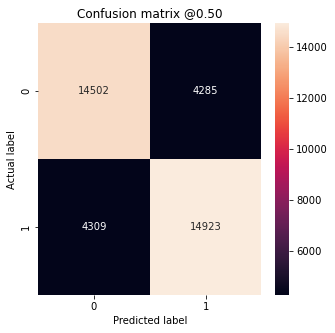

In [609]:
baseline_results = model.evaluate(test_data, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


In [610]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

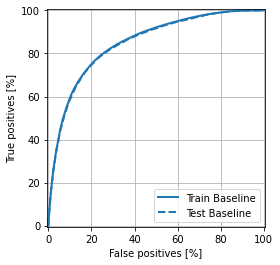

In [611]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');


In [612]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


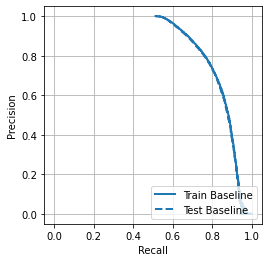

In [613]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');


# Render

In [614]:
save_notebook()
time.sleep(3)
output_HTML(current_file, output_file)